In [8]:
using Revise

using BilevelTrajOpt
using ForwardDiff
using DiffResults
using Plots
using LaTeXStrings

In [4]:
# Problem taken from:
# Sinha, Ankur, Pekka Malo, and Kalyanmoy Deb. 
# "A review on bilevel optimization: from classical to evolutionary approaches and applications." 
# IEEE Transactions on Evolutionary Computation 22.2 (2018): 276-295.

α = 10.
β = .2

δl = 1.
δf = 2.
γl = .3
γf = 5.8
cl = 10.
cf = 1.

P = (ql,qf) -> α - β*(ql + qf)
Cl = ql -> δl*ql*ql + γl*ql + cl
Cf = qf -> δf*qf*qf + γf*qf + cf

#7 (generic function with 1 method)

In [ ]:
# closed form solution

qlopt = (2. * (β + δf)*(α - γl)-β * (α - γf))/(4. * (β + δf)*(β + δl) - 2. * β^2)
qfopt = (α - γf)/(2. * (β + δf)) - (β * (α - γl) - (β^2 * (α - γf))/(2. * (β + δf)))/(4. * (β + δf) * (β + δl) - 2. * β^2)

display(qlopt)
display(qfopt)

In [ ]:
# solution using our bilevel solver

function F(ql)
    fqf = qf -> -(P(ql[1],qf[1])*qf[1] - Cf(qf[1]))
    hqf = qf -> [0.]
    gqf = qf -> -qf
    qf0 = [0.]
    λ0 = [0.]
    μ0 = [0.]
    qfsol,λsol,μsol = auglag_solve(qf0,λ0,μ0,fqf,hqf,gqf,in_place=false)
    
    J = -(P(ql[1],qfsol[1])*ql[1] - Cl(ql[1]))
    c = -ql
    
    vcat(J,c)
end

ql0 = [0.]
Fres = DiffResults.JacobianResult(F(ql0),ql0)
num_g = 1
function bilevel_prob(ql)
    ForwardDiff.jacobian!(Fres, F, ql)
    Fv = DiffResults.value(Fres)
    FJ = DiffResults.jacobian(Fres)
        
    J = Fv[1]
    c = Fv[2:1+num_g]

    gJ = FJ[1,:]
    gc = FJ[2:1+num_g,:]
    
    fail = false
    
    J, c, gJ, gc, fail
end

lb = [-1e19]
ub = [1e19]
options = Dict{String, Any}()
options["Derivative option"] = 1
options["Verify level"] = -1
options["Major optimality tolerance"] = 1e-3

qlsol, fsol, info = snopt(bilevel_prob, ql0, lb, ub, options)

display(info)
display(qlsol)

function compute_qfsol(ql)
    fqf = qf -> -(P(ql[1],qf[1])*qf[1] - Cf(qf[1]))
    hqf = qf -> [0.]
    gqf = qf -> -qf
    qf0 = [0.]
    λ0 = [0.]
    μ0 = [0.]
    qfsol,λsol,μsol = auglag_solve(qf0,λ0,μ0,fqf,hqf,gqf)
end

qfsol,λsol,μsol,Lsol = compute_qfsol(qlsol)
display(qfsol)

In [5]:
# generating plots
# αs = collect(1.:1.:10.)
# δls = collect(1.:.5:50.)
δls = sort(rand(100)*25.)
# δfs = sort(rand(100)*25.)
βs = rand(length(δls))*10.
γfs = rand(length(δls))*25.

qlsols = zeros(length(δls))
qlopts = zeros(length(δls))

# for i = 1:length(αs)
# for i = 1:length(δfs)
for i = 1:length(δls)
    α = 100.
#     α = αs[i]
#     β = .1
    β = βs[i]

#     δl = 1.
    δl = δls[i]
    δf = 1.
#     δf = δfs[i]
    γl = 1.
#     γf = 1.
    γf = γfs[i]
    cl = 1.
    cf = 1.

    P = (ql,qf) -> α - β*(ql + qf)
    Cl = ql -> δl*ql*ql + γl*ql + cl
    Cf = qf -> δf*qf*qf + γf*qf + cf

    qlopts[i] = (2. * (β + δf)*(α - γl)-β * (α - γf))/(4. * (β + δf)*(β + δl) - 2. * β^2)    

    function F(ql)
        fqf = qf -> -(P(ql[1],qf[1])*qf[1] - Cf(qf[1]))
        hqf = qf -> [0.]
        gqf = qf -> -qf
        qf0 = [0.]
        λ0 = [0.]
        μ0 = [0.]
        qfsol,λsol,μsol = auglag_solve(qf0,λ0,μ0,fqf,hqf,gqf,in_place=false)

        J = -(P(ql[1],qfsol[1])*ql[1] - Cl(ql[1]))
        c = -ql

        vcat(J,c)
    end
    
    ql0 = [0.]
    Fres = DiffResults.JacobianResult(F(ql0),ql0)
    num_g = 1
    function bilevel_prob(ql)
        ForwardDiff.jacobian!(Fres, F, ql)
        Fv = DiffResults.value(Fres)
        FJ = DiffResults.jacobian(Fres)

        J = Fv[1]
        c = Fv[2:1+num_g]

        gJ = FJ[1,:]
        gc = FJ[2:1+num_g,:]

        fail = false

        J, c, gJ, gc, fail
    end

    lb = [-1e19]
    ub = [1e19]
    options = Dict{String, Any}()
    options["Derivative option"] = 1
    options["Verify level"] = -1
    options["Major optimality tolerance"] = 1e-4

    qlsol, fsol, info = snopt(bilevel_prob, ql0, lb, ub, options)
    qlsols[i] = qlsol[1]
end

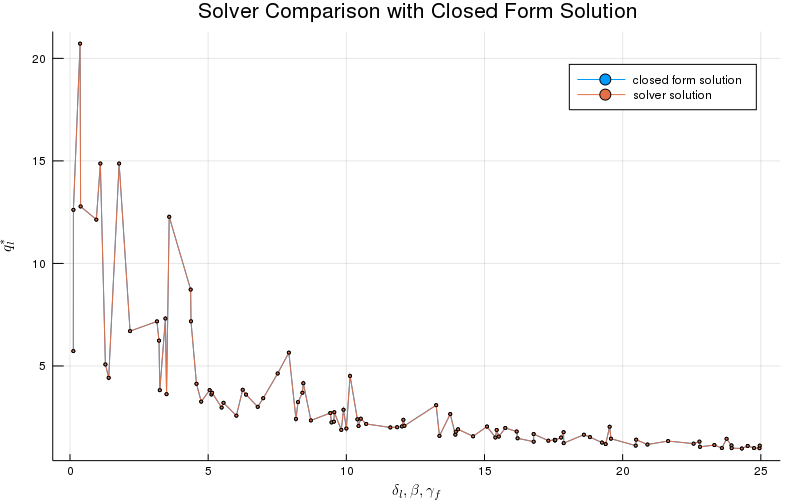

In [10]:
gr(size=(800,500), html_output_format=:png);
plot(δls,qlopts,label="closed form solution",marker=2,
    title="Solver Comparison with Closed Form Solution",
    xlabel=latexstring("\\delta_l,\\beta,\\gamma_f"),
    ylabel=latexstring("q_l^*"))
plot!(δls,qlsols,label="solver solution",marker=2)

In [11]:
png("closed_form")